## Distribution comparison
The goal of this notebook is to compare the intra vs. inter dataset distributions to compare the real data to our synthetic, generated equivalent.

### Import modules and set some paths

In [1]:
import sys
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
from tqdm import tqdm
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from skimage import io
from skimage.draw import circle, line, line_aa, polygon

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models


In [2]:
sys.path.insert(0, '/home/mlomnitz/Documents/Projects/pose2pose/')

In [3]:
import p2p

### Load the metadata

In [4]:
p2p_df = pd.read_csv('../p2p_index.csv')
p2p_df = p2p_df[p2p_df['n_frames'] == 10]
train = p2p_df[p2p_df['set'] == 'train']
test = p2p_df[p2p_df['set'] == 'test']

In [62]:
print('{:.3f} {:.3f}'.format(len(train)/len(p2p_df), len(test)/len(p2p_df)))

0.818 0.182


In [63]:
print(len(train), len(test))

870394 194280


In [5]:
test.iloc[100]

Unnamed: 0                      920
Unnamed: 0.1                    920
name            id00019/WqlypvicTmY
snippet                   00105.mp4
n_frames                         10
set                            test
Name: 857, dtype: object

### Dataset
Define a custom dataloader for this specific task.  Per row in the metadata dataframe we will return all frames and poses as well as the PID (person identity) for our classifiers

In [6]:
class RvsGDataset(Dataset):
    """  Pose to Pose dataset definition loads two frame/pose pairs
    """

    def __init__(self, df=None, transform=None, data_path=''):
        """ Dataset initialization
        Parameters
        ----------
        df : pd.DataFrame
            Dataframe with datapoint metadata
        transform : torchvision.transforms
            Frame preprocessing transforms.  Nt applied to poses
        data_path : str
            Global path to data directory
        Returns
        -------
        """
        self.df = df
        self.data_path = data_path
        if transform is None:
            self.transform = transforms.ToTensor()
        else:
            self.transform = transform

        self.to_tensor = transforms.ToTensor()

    def __getitem__(self, idx):
        """ Returns dataset item
        Parameters
        ----------
        idx : int
            Index for desired datapoint
        Returns
        -------
        frames[0] : torch.tensor
            First (input) frame
        frames[1] : torch.tensor
            Second (target) frame
        pose : torch.tensor
            Second (target) pose
        """
        entry = self.df.iloc[idx]
        dir_path = '{}/{}/{}'.format(self.data_path,
                                     entry['name'], entry['snippet'])
        frames = [self.transform(Image.open(
            '{}/frame_{}.jpg'.format(dir_path, x))) for x in range(5)]
        poses = [self.to_tensor(Image.open(
            '{}/pose_{}.jpg'.format(dir_path, x))) for x in range(5)]
        
        pid = int((entry['name'].split('/')[0])[2:])

        return frames, poses, pid

    def __len__(self):
        """ Lenght of dataset
        Parameters
        ----------
        Returns
        -------
        len : int
            Len of dataframe/dataset           
        """
        return len(self.df)



### Face-id model
Define the face-id model used to extreact feature and study the distributions

In [7]:
class VoxFaceID(nn.Module):
    def __init__(self, pretrain_path=None, 
                 device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')):
        super(VoxFaceID, self).__init__()
        model = models.resnet34(pretrained=False)
        model.fc = nn.Linear(in_features=512, out_features=5994, bias=True)
        if pretrain_path:
            print('Loading pretrained weights')
            chpt = torch.load(pretrain_path)
            model.load_state_dict(chpt['frame model'])
        features = list(model.children())[:-1]
        self.features = nn.Sequential(*features).to(device)
        self.fc = model.fc.to(device)
        #
        self.inv_mean = torch.tensor([-1., -1., -1.]).to(device)
        self.inv_mean = self.inv_mean.view(-1, 1, 1)

        self.inv_std = torch.tensor([2., 2., 2.]).to(device)
        self.inv_std = self.inv_std.view(-1, 1, 1)
        #
        self.mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
        self.mean = self.mean.view(-1, 1, 1)
        self.std = torch.tensor([0.229, 0.224, 0.225]).to(device)
        self.std = self.std.view(-1, 1, 1)


    def renormalize(self, tensor):
        """ Generator to ImageNet normalization
        Parameters
        ----------
        tensor : torch.tensor
            Image tensor to renormalize to accomodate ImageNet norm   
        Returns
         -------
        new_tensor : torch.tensor
            Renormalized image tensor
        """
        new_tensor = (tensor-self.inv_mean)/self.inv_std
        return (new_tensor-self.mean)/self.std    
    
    def get_embeddings(self, x):
        self.renormalize(x)
        x = self.features(x)
        return x.reshape(x.shape[0], -1)
    
    def get_class(self, x):
        return self.fc(x)

### Load pretrained weights
Pretrained weights for:
- pose2pose generator
- face-id model pretrained on VoxCeleb pid

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
faceid = VoxFaceID(pretrain_path='/home/mlomnitz/Documents/Projects/pose2pose/p2p/pretrained/pretrained_VoxFaceID.pth.tar', 
                   device=device)
generator = p2p.GlobalGenerator(input_nc=6, output_nc=3)
chpt = torch.load('../weights/vgg_mse/checkpoint_49.pth.tar')
generator.load_state_dict(chpt['generator'])
generator.to(device)

Loading pretrained weights


GlobalGenerator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(6, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (11): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): ResnetBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 

### Frame transforms and dataloader

In [9]:
frame_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

testset = RvsGDataset(df=test, transform=frame_transform, data_path='/home/mlomnitz/Documents/Projects/pose2pose/data/p2p')
testloader = DataLoader(testset, batch_size=32, shuffle=True, num_workers=32)

In [10]:
frames, poses, ids = iter(testloader).next()

([], <a list of 0 Text yticklabel objects>)

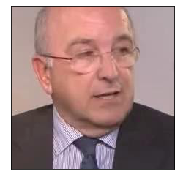

In [11]:
from p2p.utils import prepare_image
fig = plt.figure(figsize = (3, 3))
plt.imshow(prepare_image(frames[0][4]))
plt.xticks([])
plt.yticks([])

In [12]:
input_ = torch.cat([frames[0], poses[1]], dim=1)

In [13]:
preds = generator(input_.to(device))

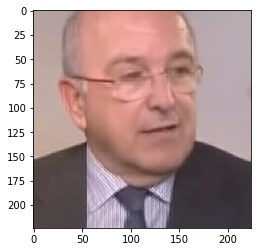

In [14]:
plt.imshow(prepare_image(preds[4].detach().cpu()))

### Visualizing an example
Before full blown statistical test we compare the real and synthetic equivalents for frames 1-5

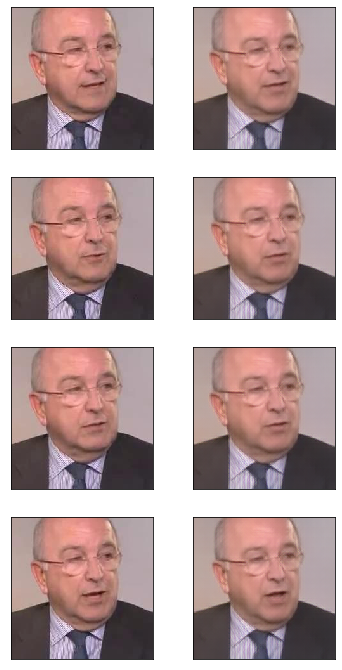

In [15]:
idx = 4
fig = plt.figure(figsize=(6, 12))
iplot = 0
with torch.no_grad():
    for ipose in range(1, 5):
        del preds
        preds = generator(torch.cat([frames[idx], poses[ipose]], dim=1).to(device))
        plt.subplot(4, 2, iplot+1)
        plt.imshow(prepare_image(frames[ipose][idx].cpu()))
        plt.xticks([])
        plt.yticks([])
        plt.subplot(4, 2, iplot+2)
        plt.imshow(prepare_image(preds[idx].cpu()))
        iplot+=2
        plt.xticks([])
        plt.yticks([])

### Distribution test
Routing for comparison.  Per row in the validation set we will select frame0 as a source and the compare the features, extracted using the face-id model, between:
- frame0 and frames1-4 
- frame0 and generated1-4

In [16]:

def runComparison(generator, faceid, testloader, device):
    real_distances = []
    real_accuracy = 0
    gen_distances = []
    gen_accuracy = 0
    frame_2_frame = []
    total = 0
    #
    generator.eval()
    faceid.eval()
    #
    loss = torch.nn.CosineEmbeddingLoss()
    ones = torch.ones((1), requires_grad=False).to(device)
    pbar = tqdm(total=len(testloader))
    with torch.no_grad():
        for ibatch, batch in enumerate(testloader):
            pbar.update(1)
            frames, poses, ids = batch
            batch_size=ids.shape[0]
            ids = ids.to(device)
            source = frames[0].to(device)
            s_embeddings = faceid.get_embeddings(source)
            ids.to(device)
            for ipose in range(1, 5):
                input_ = torch.cat([source, poses[ipose].to(device)], dim=1)
                target = frames[ipose].to(device)
                preds = generator(input_)
                p_embeddings = faceid.get_embeddings(preds)
                p_class = faceid.get_class(p_embeddings)
                t_embeddings = faceid.get_embeddings(target)
                t_class = faceid.get_class(t_embeddings)
                #
                gen_distances.append(loss(p_embeddings, s_embeddings, ones).item())
                real_distances.append(loss(t_embeddings, s_embeddings, ones).item())
                frame_2_frame.append(loss(p_embeddings, t_embeddings, ones).item())
                #
                p_pred = p_class.argmax(dim=1)
                gen_accuracy += p_pred.eq(ids).sum().item()
                #
                t_pred = t_class.argmax(dim=1)
                real_accuracy += t_pred.eq(ids).sum().item()
                #
                total+=batch_size
    pbar.reset()
    pbar.close()
    return real_distances, real_accuracy/total, gen_distances, gen_accuracy/total, frame_2_frame
    

In [17]:
stats = runComparison(generator=generator, faceid=faceid, testloader=testloader, device=device)

  0%|          | 0/6072 [00:00<?, ?it/s]             


In [18]:
print(stats[1], stats[3])

6.4340127650813255e-06 2.5736051060325302e-05


(array([  48.,  586., 2547., 5549., 6946., 5302., 2426.,  714.,  153.,
          17.]),
 array([0.04589092, 0.05252533, 0.05915973, 0.06579414, 0.07242854,
        0.07906295, 0.08569736, 0.09233176, 0.09896617, 0.10560057,
        0.11223498]),
 <a list of 10 Patch objects>)

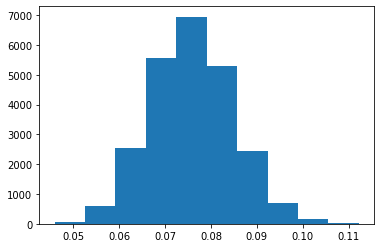

In [19]:
plt.hist(stats[0])

(array([  80.,  823., 3218., 6238., 6823., 4523., 1905.,  548.,  114.,
          16.]),
 array([0.04560151, 0.05334745, 0.0610934 , 0.06883934, 0.07658528,
        0.08433123, 0.09207717, 0.09982311, 0.10756906, 0.115315  ,
        0.12306094]),
 <a list of 10 Patch objects>)

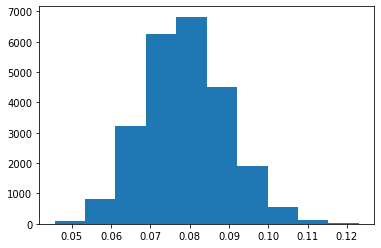

In [20]:
plt.hist(stats[2])

In [ ]:
np_real = np.array(stats[0])
np_syn = np.array(stats[2])

### Making final plots

In [21]:
import seaborn as sns

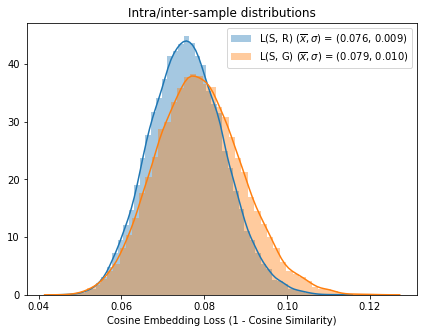

In [56]:
fig = plt.figure(figsize=(7,5))
label1 = 'L(S, R) ($\overline{x}, \sigma$) =' + ' ({:.3f}, {:.3f})'.format(np_real.mean(), np_real.std())
label2 = 'L(S, G) ($\overline{x}, \sigma$) =' + ' ({:.3f}, {:.3f})'.format(np_syn.mean(), np_syn.std())
sns.distplot(stats[0], label=label1)
sns.distplot(stats[2], label=label2)
plt.legend()
plt.title('Intra/inter-sample distributions')
plt.xlabel('Cosine Embedding Loss (1 - Cosine Similarity)')
plt.savefig('./test_2.png')

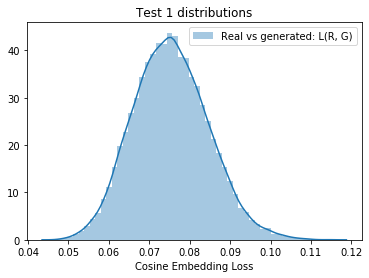

In [23]:
fig = plt.figure(figsize=(6,4))
sns.distplot(stats[4], label='Real vs generated: L(R, G)')
plt.legend()
plt.title('Test 1 distributions')
plt.xlabel('Cosine Embedding Loss')
plt.savefig('./test_1.png')

In [31]:
import math
def get_z(a, b):
    sig_a2 = a.std()**2/len(a)
    sig_b2 = b.std()**2/len(b)
    return (a.mean()-b.mean())/math.sqrt(sig_a2 + sig_b2)

In [32]:
print(get_z(np_real, np_syn))

-34.188792342858925


In [43]:
print(np_real.mean(), np_real.std())

0.07586290926595214 0.008927115020004399


In [42]:
print(np_syn.mean(), np_syn.std())

0.07887578277792831 0.010436755979496856


In [39]:
0.07586290926595214 - 0.07887578277792831

-0.003012873511976169

In [41]:
(3.2811834066365336e-09+4.484761008545922e-09)**1/2

3.882972207591228e-09